Processando eventos de sinal...
#--------------------------------------------------------------------------
#                         FastJet release 3.4.2
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------
Eventos lidos: 500
Uso de memória: 799.

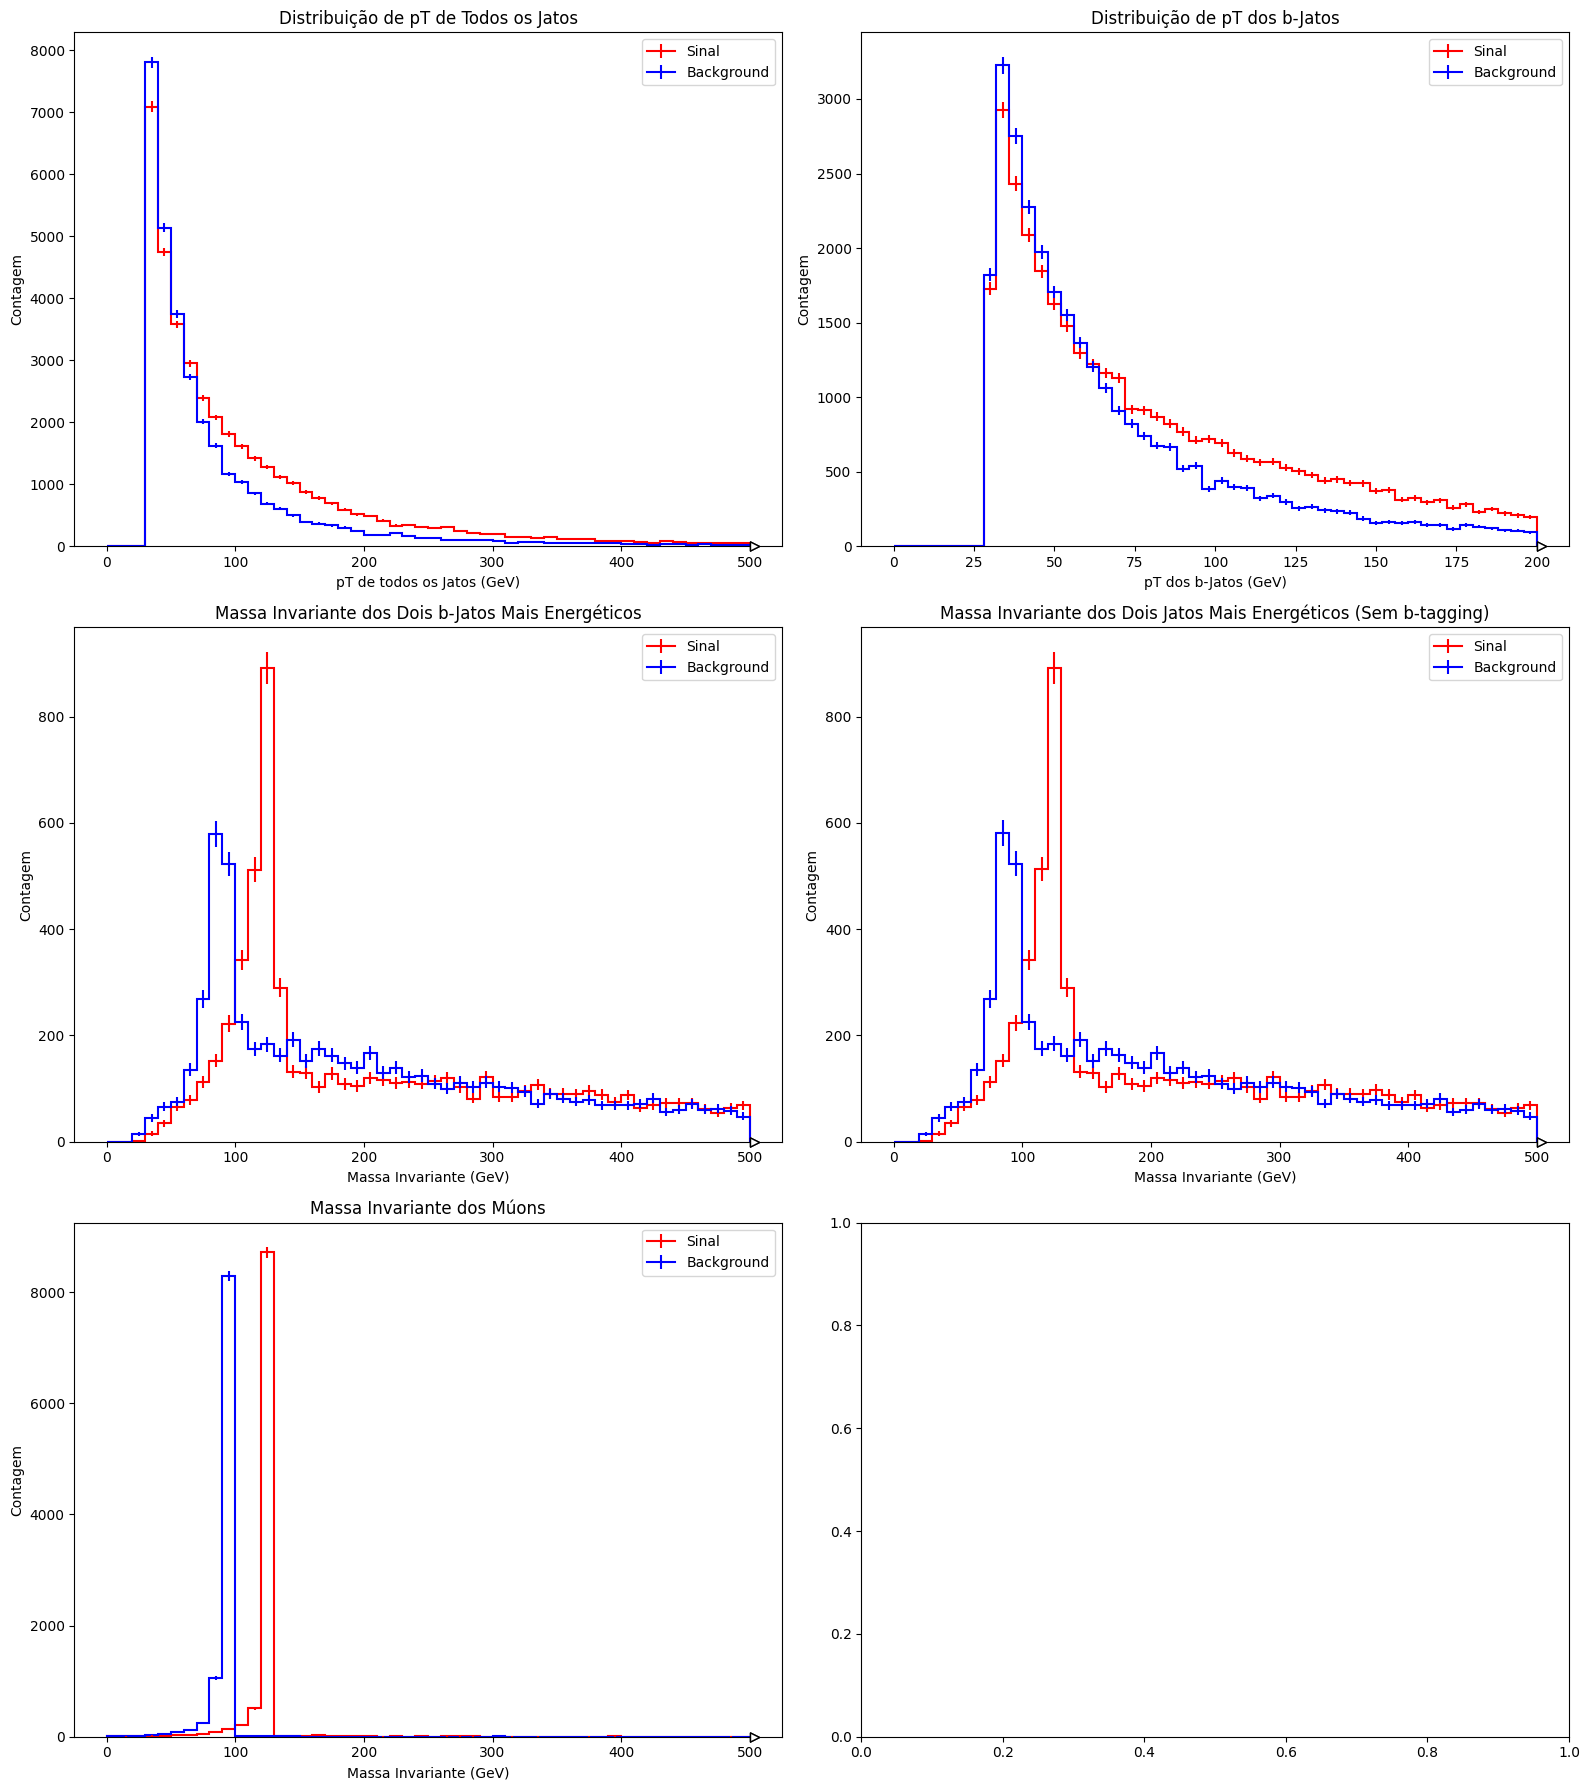

In [1]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Identificar pares de múons com cargas opostas e de maior pT
        muon_pairs = find_opposite_charge_muons(particles)
        if muon_pairs:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Remover esses múons da lista de partículas
            particles_no_muons = [p for p in particles_no_muons if p not in selected_pair]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background em chunks
print("\nProcessando eventos de background...")
for chunk in read_hepmc_file_in_chunks(background_file):
    analyze_events(chunk, histo_jets_pt_bg, histo_bjets_pt_bg, histo_bjets_mass_bg, histo_jets_mass_bg)
    analyze_muons(chunk, histo_muons_mass_bg)

# Plotar histogramas
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg.plot(ax=ax[0, 0], label='Background', color='blue')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg.plot(ax=ax[0, 1], label='Background', color='blue')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg.plot(ax=ax[1, 0], label='Background', color='blue')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg.plot(ax=ax[1, 1], label='Background', color='blue')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

# Histogramas da massa invariante dos múons
histo_muons_mass_sinal.plot(ax=ax[2, 0], label='Sinal', color='red')
histo_muons_mass_bg.plot(ax=ax[2, 0], label='Background', color='blue')
ax[2, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Múons')
ax[2, 0].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1757.68 MB
Eventos lidos: 1000
Uso de memória: 1754.91 MB
Eventos lidos: 1500
Uso de memória: 1742.62 MB
Eventos lidos: 2000
Uso de memória: 1742.44 MB
Eventos lidos: 2500
Uso de memória: 1744.87 MB
Eventos lidos: 3000
Uso de memória: 1744.87 MB
Eventos lidos: 3500
Uso de memória: 1744.87 MB
Eventos lidos: 4000
Uso de memória: 1744.86 MB
Eventos lidos: 4500
Uso de memória: 1744.86 MB
Eventos lidos: 5000
Uso de memória: 1746.40 MB
Eventos lidos: 5500
Uso de memória: 1750.01 MB
Eventos lidos: 6000
Uso de memória: 1750.01 MB
Eventos lidos: 6500
Uso de memória: 1750.52 MB
Eventos lidos: 7000
Uso de memória: 1765.99 MB
Eventos lidos: 7500
Uso de memória: 1765.99 MB
Eventos lidos: 8000
Uso de memória: 1767.54 MB
Eventos lidos: 8500
Uso de memória: 1767.54 MB
Eventos lidos: 9000
Uso de memória: 1767.54 MB
Eventos lidos: 9500
Uso de memória: 1767.54 MB
Eventos lidos: 10000
Uso de memória: 1767.54 MB

Processando eventos de back

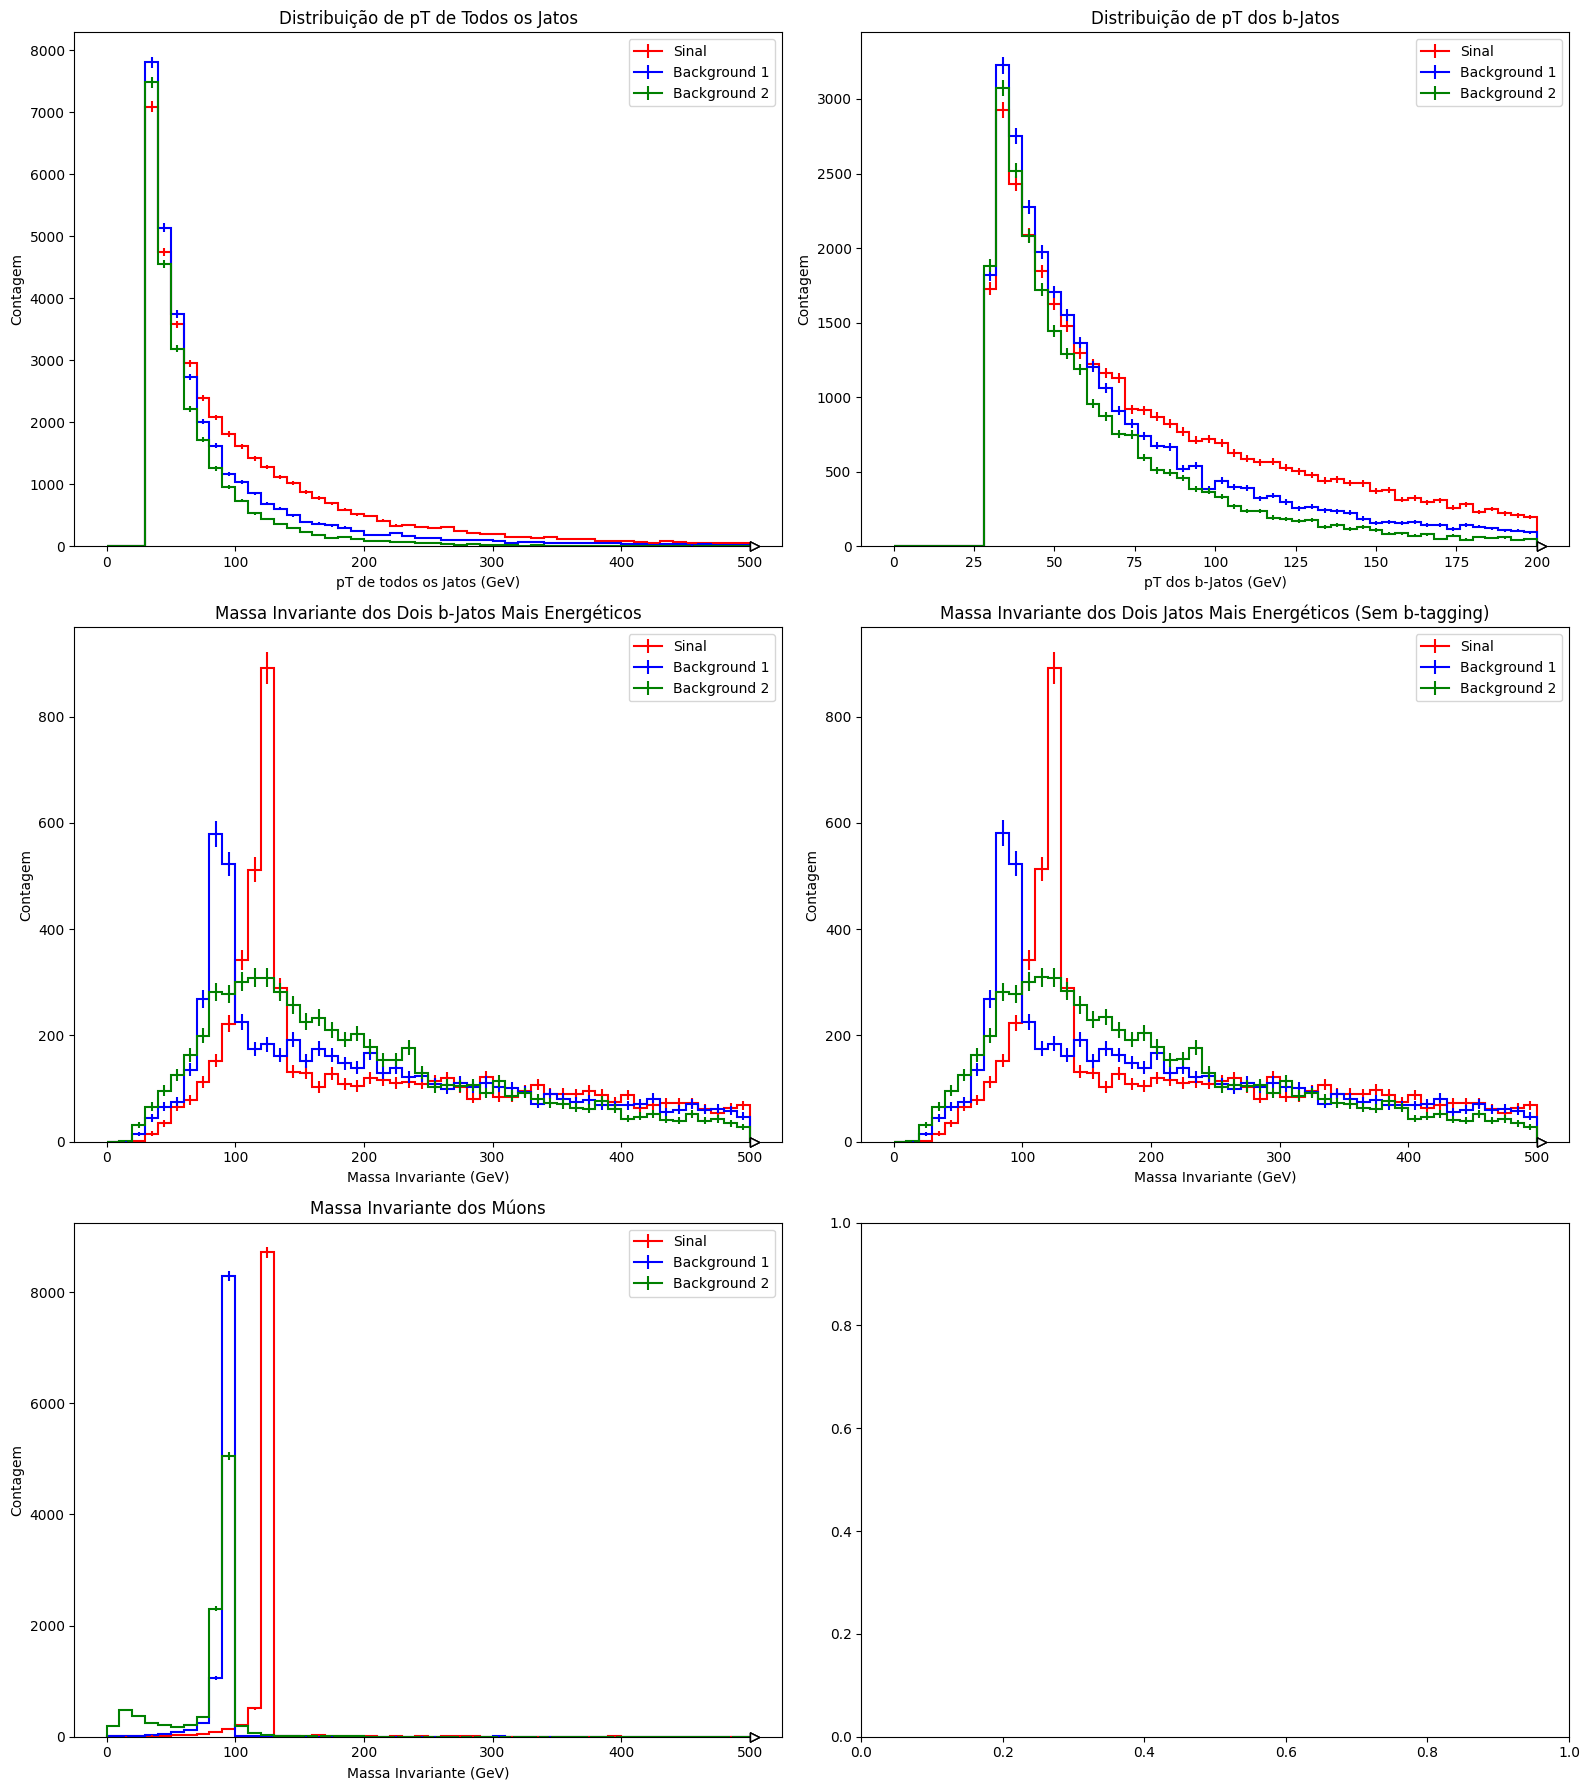

In [2]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg1 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg2 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass, histo_jets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Identificar pares de múons com cargas opostas e de maior pT
        muon_pairs = find_opposite_charge_muons(particles)
        if muon_pairs:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Remover esses múons da lista de partículas
            particles_no_muons = [p for p in particles_no_muons if p not in selected_pair]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Selecionar os dois jatos de maior pT (sem b-tagging)
        if len(jets) >= 2:
            jets_sorted = sorted(jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            jets_selected = jets_sorted[:2]
            
            # Calcular a massa invariante dos dois jatos selecionados
            mass = invariant_mass(jets_selected[0], jets_selected[1])
            
            # Preencher histograma da massa invariante dos jatos (sem b-tagging)
            histo_jets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal, histo_jets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background 1 em chunks
print("\nProcessando eventos de background 1...")
for chunk in read_hepmc_file_in_chunks(background_file1):
    analyze_events(chunk, histo_jets_pt_bg1, histo_bjets_pt_bg1, histo_bjets_mass_bg1, histo_jets_mass_bg1)
    analyze_muons(chunk, histo_muons_mass_bg1)

# Processar eventos de background 2 em chunks
print("\nProcessando eventos de background 2...")
for chunk in read_hepmc_file_in_chunks(background_file2):
    analyze_events(chunk, histo_jets_pt_bg2, histo_bjets_pt_bg2, histo_bjets_mass_bg2, histo_jets_mass_bg2)
    analyze_muons(chunk, histo_muons_mass_bg2)

# Plotar histogramas
fig, ax = plt.subplots(3, 2, figsize=(16, 18))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg1.plot(ax=ax[0, 0], label='Background 1', color='blue')
histo_jets_pt_bg2.plot(ax=ax[0, 0], label='Background 2', color='green')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg1.plot(ax=ax[0, 1], label='Background 1', color='blue')
histo_bjets_pt_bg2.plot(ax=ax[0, 1], label='Background 2', color='green')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg1.plot(ax=ax[1, 0], label='Background 1', color='blue')
histo_bjets_mass_bg2.plot(ax=ax[1, 0], label='Background 2', color='green')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos dois jatos mais energéticos (sem b-tagging)
histo_jets_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_jets_mass_bg1.plot(ax=ax[1, 1], label='Background 1', color='blue')
histo_jets_mass_bg2.plot(ax=ax[1, 1], label='Background 2', color='green')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois Jatos Mais Energéticos (Sem b-tagging)')
ax[1, 1].legend()

# Histogramas da massa invariante dos múons
histo_muons_mass_sinal.plot(ax=ax[2, 0], label='Sinal', color='red')
histo_muons_mass_bg1.plot(ax=ax[2, 0], label='Background 1', color='blue')
histo_muons_mass_bg2.plot(ax=ax[2, 0], label='Background 2', color='green')
ax[2, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Múons')
ax[2, 0].legend()

plt.tight_layout()
plt.show()

Processando eventos de sinal...
Eventos lidos: 500
Uso de memória: 1791.76 MB
Eventos lidos: 1000
Uso de memória: 1792.02 MB
Eventos lidos: 1500
Uso de memória: 1791.97 MB
Eventos lidos: 2000
Uso de memória: 1792.74 MB
Eventos lidos: 2500
Uso de memória: 1793.63 MB
Eventos lidos: 3000
Uso de memória: 1793.62 MB
Eventos lidos: 3500
Uso de memória: 1794.39 MB
Eventos lidos: 4000
Uso de memória: 1794.27 MB
Eventos lidos: 4500
Uso de memória: 1794.27 MB
Eventos lidos: 5000
Uso de memória: 1794.27 MB
Eventos lidos: 5500
Uso de memória: 1793.59 MB
Eventos lidos: 6000
Uso de memória: 1792.42 MB
Eventos lidos: 6500
Uso de memória: 1790.29 MB
Eventos lidos: 7000
Uso de memória: 1789.30 MB
Eventos lidos: 7500
Uso de memória: 1789.30 MB
Eventos lidos: 8000
Uso de memória: 1785.43 MB
Eventos lidos: 8500
Uso de memória: 1782.46 MB
Eventos lidos: 9000
Uso de memória: 1782.46 MB
Eventos lidos: 9500
Uso de memória: 1781.96 MB
Eventos lidos: 10000
Uso de memória: 1781.96 MB

Processando eventos de back

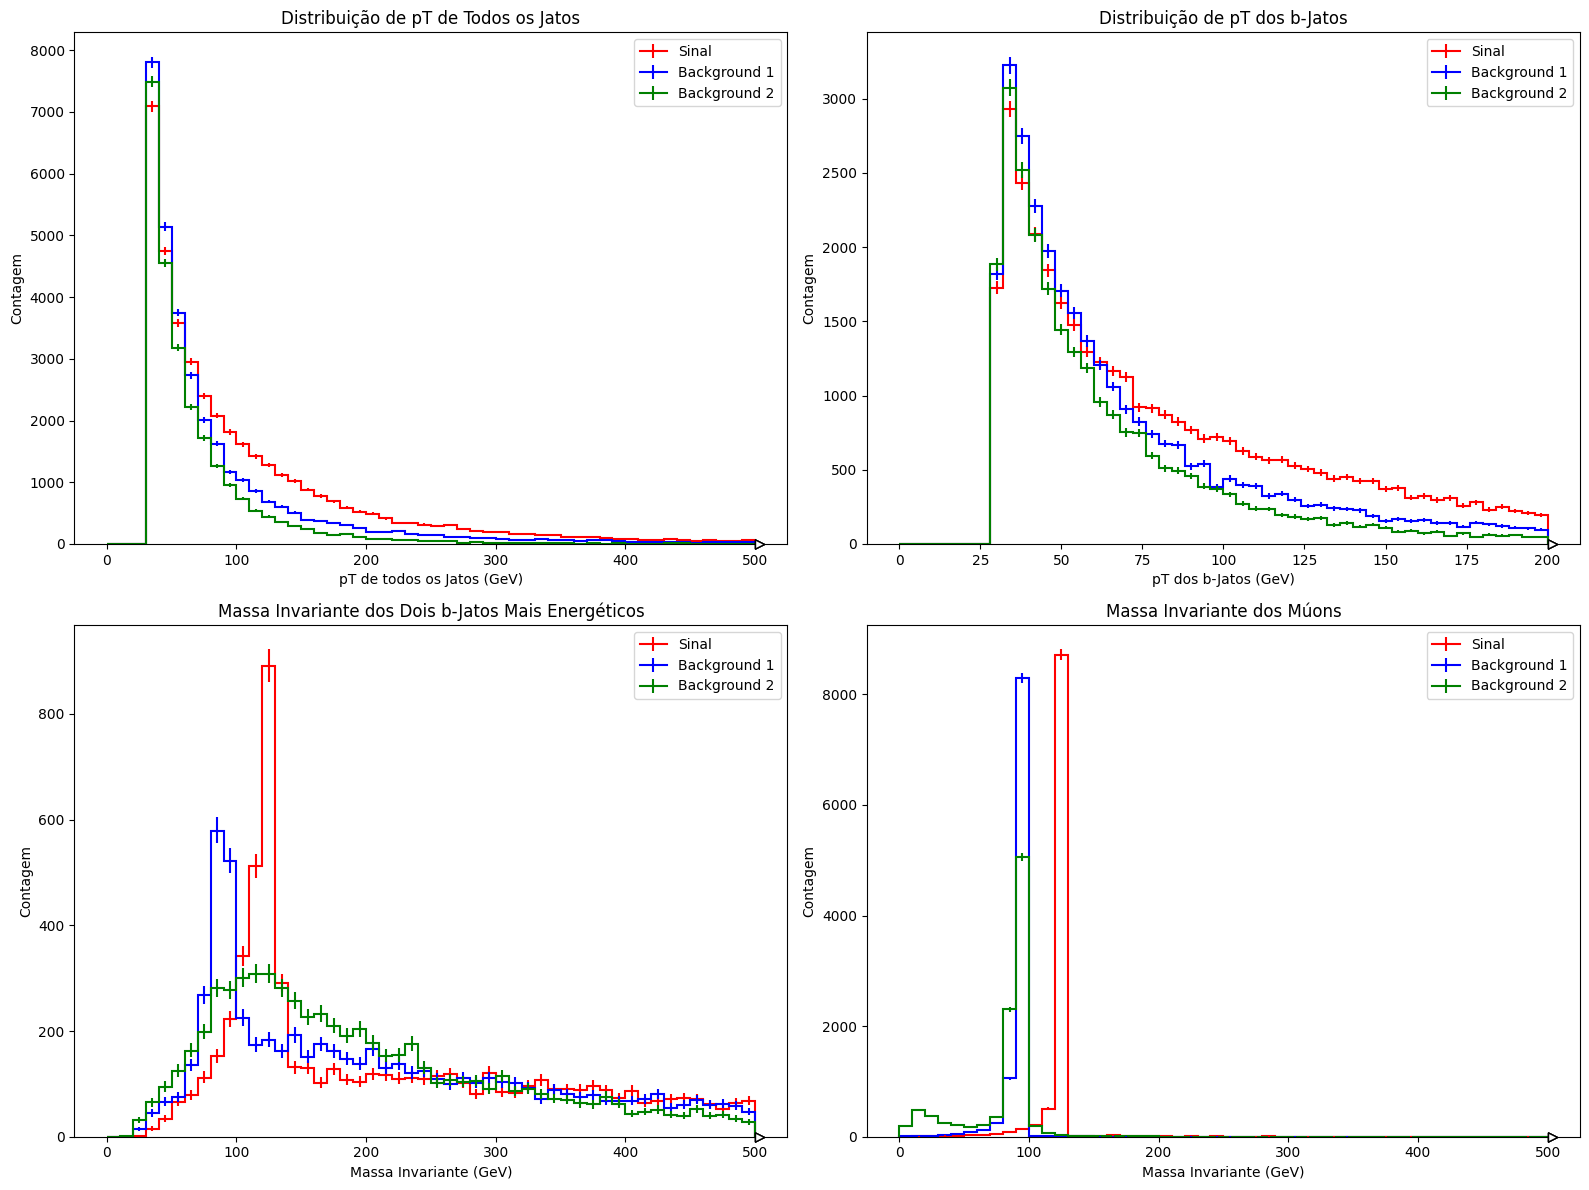

In [4]:
import pyhepmc as hep
import numpy as np
import hist
import matplotlib.pyplot as plt
import fastjet as fj
import psutil
import os
import gc

# Função para verificar o uso de memória
def print_memory_usage():
    process = psutil.Process(os.getpid())
    print(f"Uso de memória: {process.memory_info().rss / 1024 ** 2:.2f} MB")

# Limite máximo de eventos
max_events = 10000  # Total de eventos a serem processados
chunk_size = 500   # Eventos por chunk

# Definir arquivos de entrada
sinal_file = '/home/levi/Documentos/Sinal_background/pp_hh_100TeV.hepmc'
background_file1 = '/home/levi/Documentos/Sinal_background/pp_zz_background_nobornQCD.hepmc'
background_file2 = '/home/levi/Documentos/Sinal_background/background_pp_jjmumu.hepmc'

# Definir histogramas
histo_jets_pt_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_jets_pt_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_pt_sinal = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg1 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_pt_bg2 = hist.Hist.new.Reg(50, 0., 200.).Double()
histo_bjets_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_bjets_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_sinal = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg1 = hist.Hist.new.Reg(50, 0., 500.).Double()
histo_muons_mass_bg2 = hist.Hist.new.Reg(50, 0., 500.).Double()

# Função para ler eventos HEPMC em chunks
def read_hepmc_file_in_chunks(hepmc_file, max_events=max_events, chunk_size=chunk_size):
    events = []
    with hep.open(hepmc_file) as f:
        for i, event in enumerate(f):
            if i >= max_events:
                break
            events.append(event)
            if (i + 1) % chunk_size == 0:  # Processar chunk
                yield events
                events = []  # Limpar lista de eventos
                print(f"Eventos lidos: {i + 1}")
                print_memory_usage()
                gc.collect()  # Forçar liberação de memória
        if events:  # Processar eventos restantes
            yield events

# Função para verificar se um jato é b-tagged
def is_b_tagged(jet, particles, cone_radius=0.4):
    secondary_vertex_displacement = []
    for p in particles:
        if p.production_vertex is not None:
            r_prod = np.sqrt(p.production_vertex.position.x**2 + p.production_vertex.position.y**2)
            secondary_vertex_displacement.append(r_prod)
    if len(secondary_vertex_displacement) > 0:
        return np.mean(secondary_vertex_displacement) > 1.0
    return False

# Função para calcular a massa invariante entre dois jatos
def invariant_mass(jet1, jet2):
    E_tot = jet1.e() + jet2.e()
    px_tot = jet1.px() + jet2.px()
    py_tot = jet1.py() + jet2.py()
    pz_tot = jet1.pz() + jet2.pz()
    return np.sqrt(E_tot**2 - (px_tot**2 + py_tot**2 + pz_tot**2))

# Função para remover múons das partículas
def remove_muons(particles):
    return [p for p in particles if abs(p.pid) != 13]  # Múons têm PID ±13

# Função para identificar múons com cargas opostas e de mesmo sabor
def find_opposite_charge_muons(particles):
    muons = []
    for p in particles:
        if abs(p.pid) == 13:  # Múons têm PID ±13
            muons.append(p)
    
    # Selecionar pares de múons com cargas opostas
    muon_pairs = []
    for i in range(len(muons)):
        for j in range(i + 1, len(muons)):
            if muons[i].pid == -muons[j].pid:  # Cargas opostas
                muon_pairs.append((muons[i], muons[j]))
    
    return muon_pairs

# Função para processar eventos e preencher histograma de múons
def analyze_muons(events, histo_muons_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Identificar pares de múons com cargas opostas
        muon_pairs = find_opposite_charge_muons(particles)
        
        if len(muon_pairs) >= 1:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Criar objetos PseudoJet para os múons
            muon1 = fj.PseudoJet(selected_pair[0].momentum.x, selected_pair[0].momentum.y, selected_pair[0].momentum.z, selected_pair[0].momentum.e)
            muon2 = fj.PseudoJet(selected_pair[1].momentum.x, selected_pair[1].momentum.y, selected_pair[1].momentum.z, selected_pair[1].momentum.e)
            
            # Calcular a massa invariante
            mass = invariant_mass(muon1, muon2)
            
            # Preencher histograma da massa invariante
            histo_muons_mass.fill(mass)

# Função para processar eventos e preencher histogramas de jatos
def analyze_events(events, histo_all_jets, histo_bjets_pt, histo_bjets_mass):
    for i, event in enumerate(events):
        # Partículas do evento com status 1 (partículas estáveis)
        particles = [p for p in event.particles if p.status == 1]
        
        # Remover múons das partículas
        particles_no_muons = remove_muons(particles)
        
        # Identificar pares de múons com cargas opostas e de maior pT
        muon_pairs = find_opposite_charge_muons(particles)
        if muon_pairs:
            # Selecionar o par de múons com maior soma de pT
            selected_pair = max(muon_pairs, key=lambda pair: pair[0].momentum.pt() + pair[1].momentum.pt())
            
            # Remover esses múons da lista de partículas
            particles_no_muons = [p for p in particles_no_muons if p not in selected_pair]
        
        # Converter partículas para objetos PseudoJet do FastJet
        fj_particles = [fj.PseudoJet(p.momentum.x, p.momentum.y, p.momentum.z, p.momentum.e) for p in particles_no_muons]
        
        # Definir o algoritmo de clustering (anti-kT, R = 0.4)
        jet_def = fj.JetDefinition(fj.antikt_algorithm, 0.4)
        
        # Clusterizar as partículas em jatos
        clusterer = fj.ClusterSequence(fj_particles, jet_def)
        
        # Selecionar jatos com pT > 30 GeV
        jets = clusterer.inclusive_jets(30.0)
        
        # Preencher histograma de pT de todos os jatos
        for jet in jets:
            histo_all_jets.fill(jet.pt())
        
        # Filtrar jatos b-tagged
        b_jets = [jet for jet in jets if is_b_tagged(jet, particles_no_muons)]
        
        # Preencher histograma de pT dos jatos b-tagged
        for jet in b_jets:
            histo_bjets_pt.fill(jet.pt())
        
        # Selecionar os dois jatos de maior pT (b-tagged)
        if len(b_jets) >= 2:
            b_jets_sorted = sorted(b_jets, key=lambda j: j.pt(), reverse=True)  # Ordenar por pT
            b_jets_selected = b_jets_sorted[:2]
            
            # Verificar se os jatos selecionados são realmente b-tagged
            if all(is_b_tagged(jet, particles_no_muons) for jet in b_jets_selected):
                # Calcular a massa invariante dos dois jatos b-tagged selecionados
                mass = invariant_mass(b_jets_selected[0], b_jets_selected[1])
                
                # Preencher histograma da massa invariante dos jatos b-tagged
                histo_bjets_mass.fill(mass)
        
        # Liberar memória após processar o evento
        if (i + 1) % 1000 == 0:
            print(f"Eventos processados: {i + 1}")
            print_memory_usage()
            del event, particles, fj_particles, jets, b_jets  # Liberar memória
            gc.collect()  # Forçar liberação de memória

# Processar eventos de sinal em chunks
print("Processando eventos de sinal...")
for chunk in read_hepmc_file_in_chunks(sinal_file):
    analyze_events(chunk, histo_jets_pt_sinal, histo_bjets_pt_sinal, histo_bjets_mass_sinal)
    analyze_muons(chunk, histo_muons_mass_sinal)

# Processar eventos de background 1 em chunks
print("\nProcessando eventos de background 1...")
for chunk in read_hepmc_file_in_chunks(background_file1):
    analyze_events(chunk, histo_jets_pt_bg1, histo_bjets_pt_bg1, histo_bjets_mass_bg1)
    analyze_muons(chunk, histo_muons_mass_bg1)

# Processar eventos de background 2 em chunks
print("\nProcessando eventos de background 2...")
for chunk in read_hepmc_file_in_chunks(background_file2):
    analyze_events(chunk, histo_jets_pt_bg2, histo_bjets_pt_bg2, histo_bjets_mass_bg2)
    analyze_muons(chunk, histo_muons_mass_bg2)

# Plotar histogramas
fig, ax = plt.subplots(2, 2, figsize=(16, 12))

# Histogramas de pT de todos os jatos
histo_jets_pt_sinal.plot(ax=ax[0, 0], label='Sinal', color='red')
histo_jets_pt_bg1.plot(ax=ax[0, 0], label='Background 1', color='blue')
histo_jets_pt_bg2.plot(ax=ax[0, 0], label='Background 2', color='green')
ax[0, 0].set(xlabel='pT de todos os Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT de Todos os Jatos')
ax[0, 0].legend()

# Histogramas de pT dos jatos b-tagging
histo_bjets_pt_sinal.plot(ax=ax[0, 1], label='Sinal', color='red')
histo_bjets_pt_bg1.plot(ax=ax[0, 1], label='Background 1', color='blue')
histo_bjets_pt_bg2.plot(ax=ax[0, 1], label='Background 2', color='green')
ax[0, 1].set(xlabel='pT dos b-Jatos (GeV)', ylabel='Contagem', title='Distribuição de pT dos b-Jatos')
ax[0, 1].legend()

# Histogramas da massa invariante dos dois b-jatos mais energéticos
histo_bjets_mass_sinal.plot(ax=ax[1, 0], label='Sinal', color='red')
histo_bjets_mass_bg1.plot(ax=ax[1, 0], label='Background 1', color='blue')
histo_bjets_mass_bg2.plot(ax=ax[1, 0], label='Background 2', color='green')
ax[1, 0].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Dois b-Jatos Mais Energéticos')
ax[1, 0].legend()

# Histogramas da massa invariante dos múons
histo_muons_mass_sinal.plot(ax=ax[1, 1], label='Sinal', color='red')
histo_muons_mass_bg1.plot(ax=ax[1, 1], label='Background 1', color='blue')
histo_muons_mass_bg2.plot(ax=ax[1, 1], label='Background 2', color='green')
ax[1, 1].set(xlabel='Massa Invariante (GeV)', ylabel='Contagem', title='Massa Invariante dos Múons')
ax[1, 1].legend()

plt.tight_layout()
plt.show()